/tmp/ipython-input-2342880321.py:78: UserWarning: Glyph 129516 (\N{DNA DOUBLE HELIX}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129516 (\N{DNA DOUBLE HELIX}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


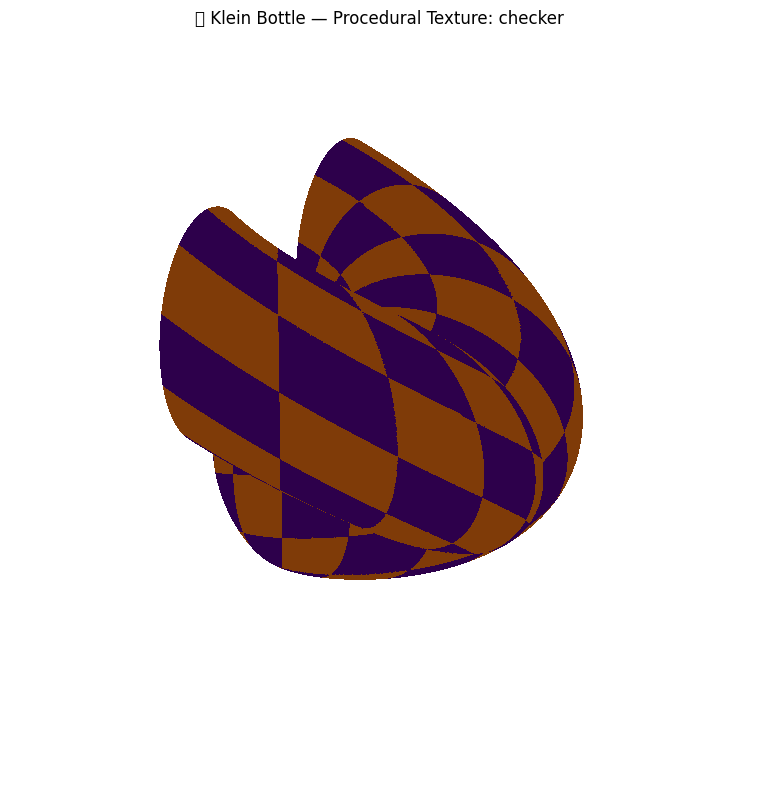

In [2]:
# STEP 0: Imports and setup
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# ---------- STEP 1: Klein bottle mesh ----------
def klein_bottle(nu=300, nv=300):
    u = np.linspace(0, 2*np.pi, nu)
    v = np.linspace(0, 2*np.pi, nv)
    u, v = np.meshgrid(u, v)
    r2 = np.sqrt(2.0)
    A = np.cos(u/2)*(r2 - np.sin(v)) + np.sin(u/2)*np.cos(v)
    X = np.cos(u) * A
    Y = np.sin(u) * A
    Z = -np.sin(u/2)*(r2 - np.sin(v)) + np.cos(u/2)*np.cos(v)
    return u, v, X, Y, Z

# ---------- STEP 2: Procedural UV textures ----------
def texture_uv_checker(u, v, tiles_u=16, tiles_v=8):
    """Checkerboard pattern in UV space -> scalar in [0,1]."""
    U = (u / (2*np.pi)) * tiles_u
    V = (v / (2*np.pi)) * tiles_v
    check = ((np.floor(U) + np.floor(V)) % 2)
    return check.astype(float)

def texture_uv_stripes(u, v, freq_u=12, freq_v=0, phase=0.0):
    """Sinusoidal stripes -> scalar in [0,1]."""
    s = np.sin(freq_u*u + freq_v*v + phase)
    return (s - s.min()) / (s.max() - s.min() + 1e-12)

def texture_uv_gradient(u, v):
    """Smooth 2D gradient in UV -> scalar in [0,1]."""
    U = (u / (2*np.pi))
    V = (v / (2*np.pi))
    g = 0.6*U + 0.4*V
    g = (g - g.min()) / (g.max() - g.min() + 1e-12)
    return g

def scalar_to_rgb(scalar, cmap=cm.viridis):
    """Map scalar [0,1] to RGB using a Matplotlib colormap."""
    rgba = cmap(np.clip(scalar, 0, 1))
    return rgba[..., :3]  # drop alpha

# ---------- STEP 3: Build and plot ----------
u, v, X, Y, Z = klein_bottle(nu=300, nv=300)

# Choose one texture: 'checker', 'stripes', or 'gradient'
mode = 'checker'  # change to 'stripes' or 'gradient'

if mode == 'checker':
    S = texture_uv_checker(u, v, tiles_u=18, tiles_v=10)
    colors_rgb = scalar_to_rgb(S, cmap=cm.PuOr)
elif mode == 'stripes':
    S = texture_uv_stripes(u, v, freq_u=14, freq_v=3, phase=0.7)
    colors_rgb = scalar_to_rgb(S, cmap=cm.magma)
elif mode == 'gradient':
    S = texture_uv_gradient(u, v)
    colors_rgb = scalar_to_rgb(S, cmap=cm.coolwarm)
else:
    raise ValueError("Unknown mode")

# Plot
fig = plt.figure(figsize=(11, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect([1, 1, 1])
ax.axis('off')

surf = ax.plot_surface(
    X, Y, Z,
    facecolors=colors_rgb,
    rstride=1, cstride=1,
    linewidth=0, antialiased=False,
    shade=False  # keep procedural colors unaltered
)

ax.set_title(f"🧬 Klein Bottle — Procedural Texture: {mode}", pad=12)
ax.view_init(elev=25, azim=35)
plt.tight_layout()
plt.show()


In [3]:
# STEP 1: Build mesh, derivatives, normals, and helpers 💡
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors

def klein_mesh(nu=300, nv=300):
    u = np.linspace(0, 2*np.pi, nu)
    v = np.linspace(0, 2*np.pi, nv)
    u, v = np.meshgrid(u, v)

    r2 = np.sqrt(2.0)
    A = np.cos(u/2)*(r2 - np.sin(v)) + np.sin(u/2)*np.cos(v)

    X = np.cos(u) * A
    Y = np.sin(u) * A
    Z = -np.sin(u/2)*(r2 - np.sin(v)) + np.cos(u/2)*np.cos(v)
    return u, v, X, Y, Z

def partials(X, Y, Z):
    Xu = np.gradient(X, axis=1); Xv = np.gradient(X, axis=0)
    Yu = np.gradient(Y, axis=1); Yv = np.gradient(Y, axis=0)
    Zu = np.gradient(Z, axis=1); Zv = np.gradient(Z, axis=0)
    ru = np.stack([Xu, Yu, Zu], axis=-1)
    rv = np.stack([Xv, Yv, Zv], axis=-1)
    n = np.cross(ru, rv)
    n_norm = np.linalg.norm(n, axis=-1, keepdims=True) + 1e-12
    n_unit = n / n_norm
    return ru, rv, n_unit

def curvature_proxy(X, Y, Z):
    # STEP 2: Simple curvature-ish scalar via Laplacian magnitude of coordinates
    # Method: |ΔX, ΔY, ΔZ| combined, normalized
    def lap(A):
        Au = np.gradient(A, axis=1); Av = np.gradient(A, axis=0)
        Auu = np.gradient(Au, axis=1); Avv = np.gradient(Av, axis=0)
        return Auu + Avv
    L = np.sqrt(lap(X)**2 + lap(Y)**2 + lap(Z)**2)
    L = (L - L.min()) / (L.max() - L.min() + 1e-12)
    return L

u, v, X, Y, Z = klein_mesh()
ru, rv, N = partials(X, Y, Z)
Kproxy = curvature_proxy(X, Y, Z)  # in [0,1]


/tmp/ipython-input-3326321283.py:8: UserWarning: Glyph 129517 (\N{COMPASS}) missing from font(s) DejaVu Sans.
  ax.view_init(25, 35); plt.tight_layout(); plt.show()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129517 (\N{COMPASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


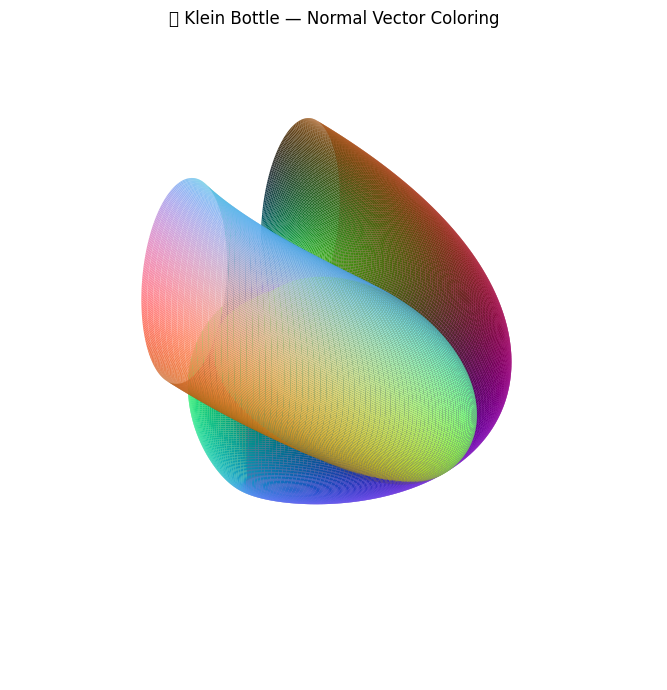

In [4]:
# STEP 3: Normal-based coloring
norm_rgb = (N + 1.0) / 2.0  # shape (M,N,3)

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d'); ax.axis('off'); ax.set_box_aspect([1,1,1])
ax.plot_surface(X, Y, Z, facecolors=norm_rgb, rstride=1, cstride=1, linewidth=0, shade=False)
ax.set_title("🧭 Klein Bottle — Normal Vector Coloring")
ax.view_init(25, 35); plt.tight_layout(); plt.show()


/tmp/ipython-input-3434915892.py:10: UserWarning: Glyph 127752 (\N{RAINBOW}) missing from font(s) DejaVu Sans.
  ax.view_init(25, 35); plt.tight_layout(); plt.show()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127752 (\N{RAINBOW}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


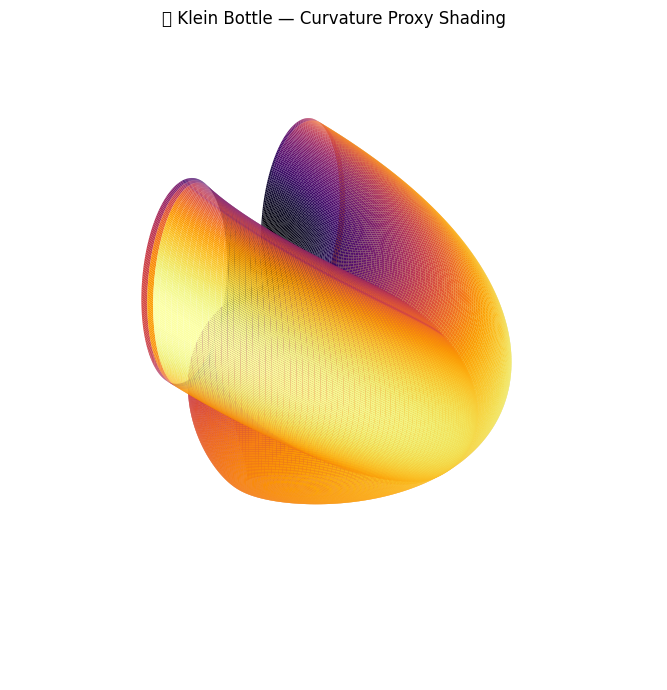

In [5]:
# STEP 4: Curvature proxy shading
curv_cmap = cm.inferno
rgba = curv_cmap(Kproxy)
curv_rgb = rgba[..., :3]

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d'); ax.axis('off'); ax.set_box_aspect([1,1,1])
ax.plot_surface(X, Y, Z, facecolors=curv_rgb, rstride=1, cstride=1, linewidth=0, shade=False)
ax.set_title("🌈 Klein Bottle — Curvature Proxy Shading")
ax.view_init(25, 35); plt.tight_layout(); plt.show()


/tmp/ipython-input-3592063645.py:18: UserWarning: Glyph 128377 (\N{JOYSTICK}) missing from font(s) DejaVu Sans.
  ax.view_init(25, 35); plt.tight_layout(); plt.show()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128377 (\N{JOYSTICK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


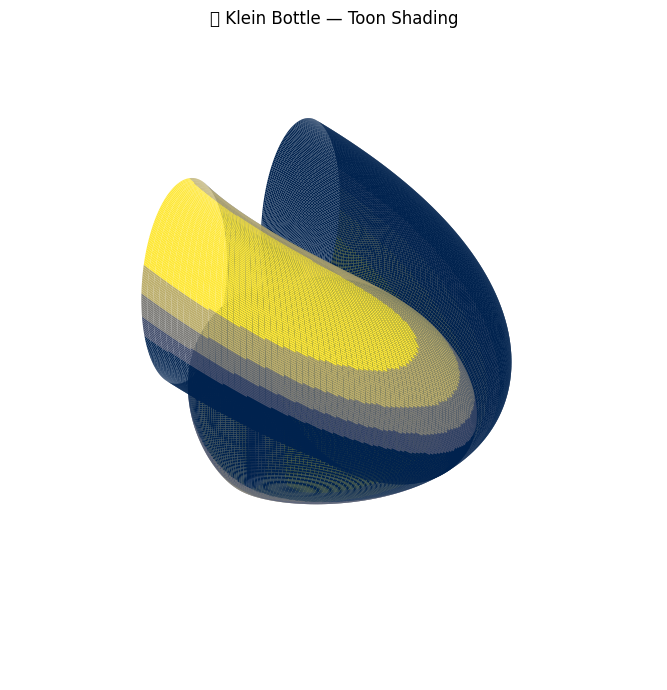

In [6]:
# STEP 5: Toon shading with quantized Lambertian
Ld = np.array([0.5, 0.4, 0.75])  # light dir
Ld = Ld / np.linalg.norm(Ld)
Ldot = np.clip(N[...,0]*Ld[0] + N[...,1]*Ld[1] + N[...,2]*Ld[2], 0, 1)

# Quantize into bands
bands = 5
toon = np.floor(Ldot * bands) / (bands - 1)
toon = np.clip(toon, 0, 1)

# Map to colors (e.g., cividis)
toon_rgb = cm.cividis(toon)[..., :3]

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d'); ax.axis('off'); ax.set_box_aspect([1,1,1])
ax.plot_surface(X, Y, Z, facecolors=toon_rgb, rstride=1, cstride=1, linewidth=0, shade=False)
ax.set_title("🕹️ Klein Bottle — Toon Shading")
ax.view_init(25, 35); plt.tight_layout(); plt.show()


/tmp/ipython-input-2605310536.py:17: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.
  ax.view_init(25, 35); plt.tight_layout(); plt.show()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


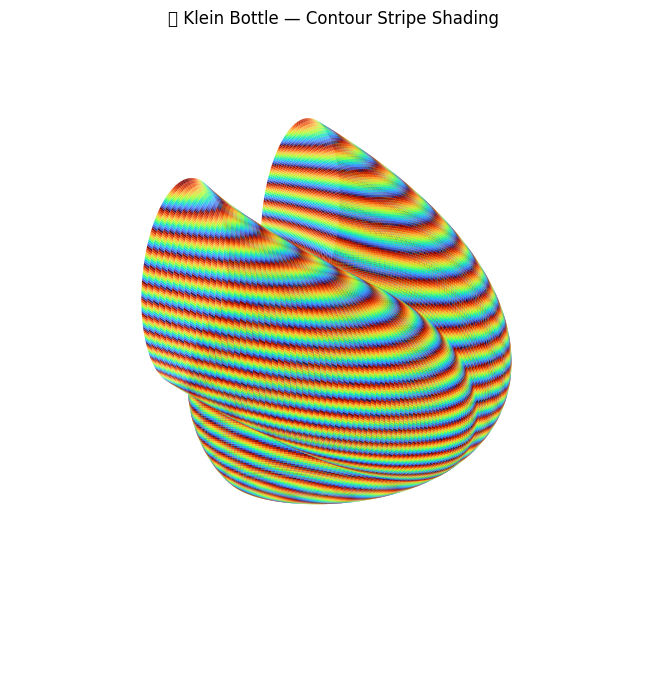

In [7]:
# STEP 6: Contour stripes via modulo
# Option 1: height-based contours
k = 22  # number of bands
zmin, zmax = Z.min(), Z.max()
Z01 = (Z - zmin) / (zmax - zmin + 1e-12)
contours = np.mod(Z01 * k, 1.0)

# Option 2: UV-based diagonal contours (uncomment to try)
# contours = np.mod((u + 0.7*v)/(2*np.pi) * k, 1.0)

contour_rgb = cm.turbo(contours)[..., :3]

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d'); ax.axis('off'); ax.set_box_aspect([1,1,1])
ax.plot_surface(X, Y, Z, facecolors=contour_rgb, rstride=1, cstride=1, linewidth=0, shade=False)
ax.set_title("📏 Klein Bottle — Contour Stripe Shading")
ax.view_init(25, 35); plt.tight_layout(); plt.show()


/tmp/ipython-input-2381268779.py:21: UserWarning: Glyph 127786 (\N{CLOUD WITH TORNADO}) missing from font(s) DejaVu Sans.
  ax.view_init(25, 35); plt.tight_layout(); plt.show()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127786 (\N{CLOUD WITH TORNADO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


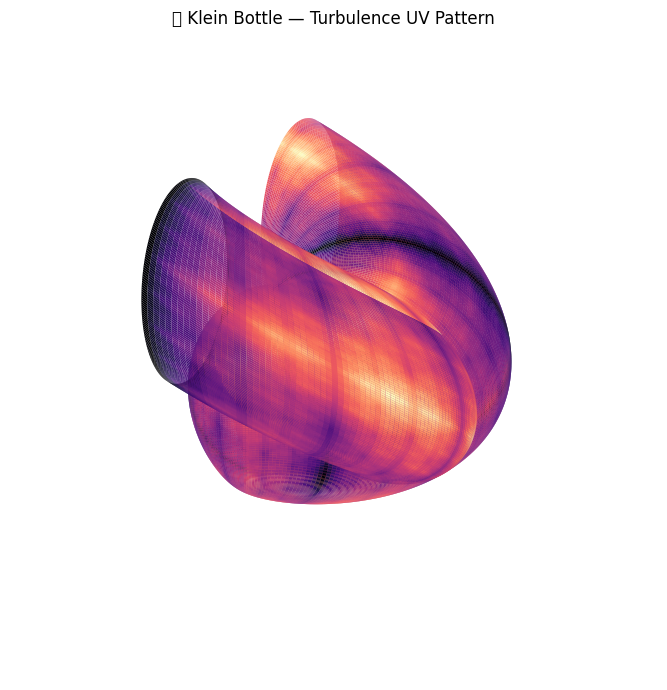

In [8]:
# STEP 7: Turbulence-like UV noise
def uv_turbulence(u, v, octaves=5, base_freq=1.5, gain=0.55):
    s = np.zeros_like(u)
    freq = base_freq
    amp = 1.0
    for _ in range(octaves):
        s += amp * np.abs(np.sin(freq*u) * np.cos(freq*v))
        freq *= 2.0
        amp *= gain
    s -= s.min()
    s /= (s.max() + 1e-12)
    return s

turb = uv_turbulence(u, v, octaves=6, base_freq=1.2, gain=0.6)
turb_rgb = cm.magma(turb)[..., :3]

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d'); ax.axis('off'); ax.set_box_aspect([1,1,1])
ax.plot_surface(X, Y, Z, facecolors=turb_rgb, rstride=1, cstride=1, linewidth=0, shade=False)
ax.set_title("🌪️ Klein Bottle — Turbulence UV Pattern")
ax.view_init(25, 35); plt.tight_layout(); plt.show()


/tmp/ipython-input-3403811091.py:26: UserWarning: Glyph 129525 (\N{SPOOL OF THREAD}) missing from font(s) DejaVu Sans.
  ax.view_init(25, 35); plt.tight_layout(); plt.show()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129525 (\N{SPOOL OF THREAD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


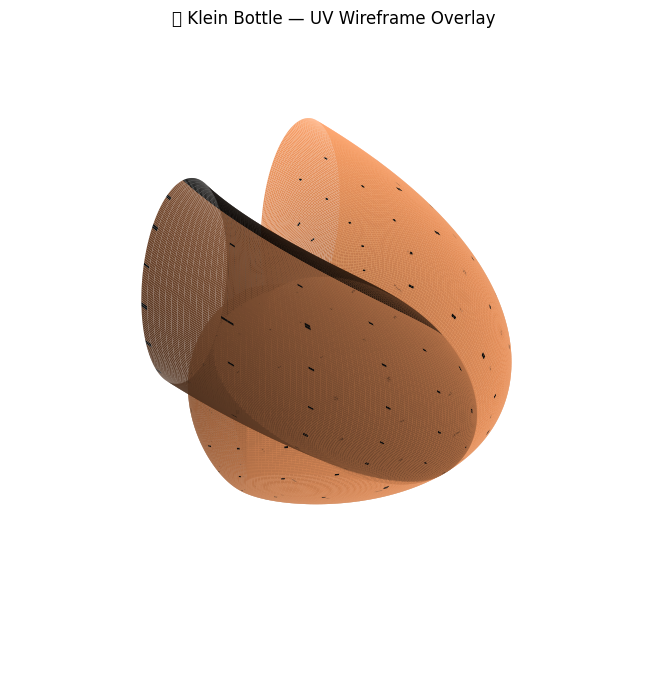

In [9]:
# STEP 8: Wireframe overlay in UV space
def uv_wire(u, v, tiles_u=20, tiles_v=14, line_width=0.06):
    U = (u/(2*np.pi))*tiles_u
    V = (v/(2*np.pi))*tiles_v
    du = np.abs(U - np.round(U))
    dv = np.abs(V - np.round(V))
    # Distance to grid lines (wrap)
    d = np.minimum(du, 1-du) + np.minimum(dv, 1-dv)
    lines = (d < line_width).astype(float)
    return lines

# Base color = smooth gradient
grad = 0.6*(u/(2*np.pi)) + 0.4*(v/(2*np.pi))
grad = (grad - grad.min())/(grad.max() - grad.min() + 1e-12)
base_rgb = cm.copper(grad)[..., :3]

# Wire mask
lines = uv_wire(u, v, tiles_u=22, tiles_v=16, line_width=0.05)
wire_color = np.array([0.05, 0.05, 0.05])  # nearly black
wire_rgb = base_rgb*(1-lines[...,None]) + wire_color*(lines[...,None])

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d'); ax.axis('off'); ax.set_box_aspect([1,1,1])
ax.plot_surface(X, Y, Z, facecolors=wire_rgb, rstride=1, cstride=1, linewidth=0, shade=False)
ax.set_title("🧵 Klein Bottle — UV Wireframe Overlay")
ax.view_init(25, 35); plt.tight_layout(); plt.show()
